# PALAVA: a pathway-inferring VAE modification for single-cell gene expression data

PALAVA is a dimension reduction model based on VAE that aims to incorporate annotated gene pathways from libraries such as MSigDB or REACTOME. The model aims to unify two previously published models:

- oi-VAE is based on VAE, but partitions the reconstruction into different interpretable groups, and attempts to prune out unhelpful latent variables from each group. This allows an interpretation of the latent representation based on the remaining variables in each group (Samuel K. Ainsworth, Nicholas J. Foti, Adrian K. C. Lee, Emily B. Fox Proceedings of the 35th International Conference on Machine Learning, PMLR 80:119-128, 2018.)
- f-scLVM is a linear method based on factor analysis that uses pathway annotations to guide inference of gene expression in single-cell RNA-seq data (Buettner et al. Genome Biology (2017) 18:212 DOI 10.1186/s13059-017-1334-8)

We modified the oi-VAE implementation to incorporate the pathway annotation idea from f-scLVM in place of the oi-VAE's 'groups'. The oi-VAE implementation can be found at: https://github.com/samuela/oi-vae

In [43]:
import sys
sys.path.append("lib")
from lib.data_sampler import DataSampler
from lib.palava import *
from lib.distributions import NormalNet
from lib.utils import Lambda, save_tensor, get_combined_norm
from itertools import permutations
import torch
import random
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.max_open_warning'] = False

random.seed(0)
torch.manual_seed(0)
dir = "output"

We will test the PALAVA model by applying to linear data, constructed according to the following matrix decomposition (Credit: Yong See Foo, A COMPARISON OF BAYESIAN INFERENCE TECHNIQUES FOR SPARSE FACTOR ANALYSIS, https://vrs.amsi.org.au/wp-content/uploads/sites/78/2020/01/foo_yong-see_vrs-report.pdf):

![MatrixFactorisation](images/MatrixFactorisation.png)

Here, the loadings refer to the mapping from high-dimensional space to low-dimensional space, and the activations refer to the low-dimensional representation of each data point - this is the representation we hope to model will discover. The product of these matrices is the original data. 

We will simulate a data set by designing a loadings matrix and activations matrix with a certain structure (the code that produces this structure can be found in "data_sampler.py"). By multplying these matrices we will reverse engineer a data set to sample from. The complexity of these matrices will determine how difficult of a 'test' the data is for the model. The model will pass the 'test' if it learns latent representations similar to those we specified in the activations matrix.

First we will design the structure of the loadings and activations:

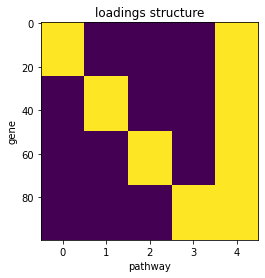

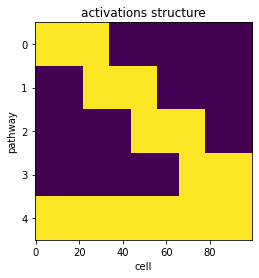

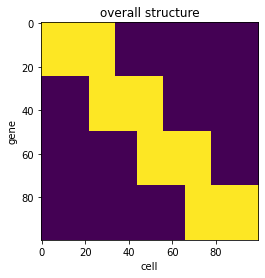

In [44]:
num_facs = 5
num_genes = 100
num_cells = 100

sampler = DataSampler(
  num_facs, num_genes, num_cells, overlap=True, dense_fac=True
)
sampler.save_matrices(dir + "/structure", overwrite=True, structure=True)

We then sample from the activations and loadings structure, to give the actual activations and loadings. We will sample from a normal distribution with mean 0, and the standard deviation will vary based on the structure given above. Dense pathways are given their own standard deviation. We then multiply the two matrices, and add noise that is also from a normal distribution, to give the dataset we will use throughout the simulation

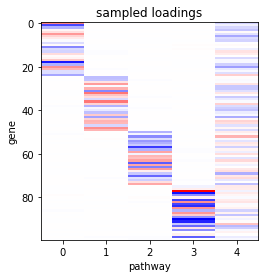

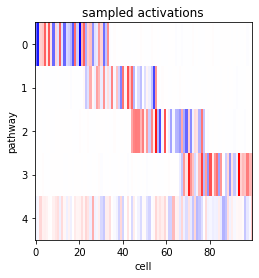

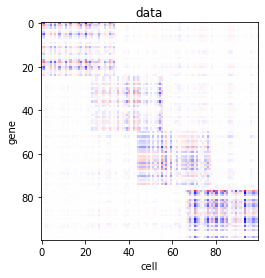

In [45]:
zero_sd = 0.01
nonzero_sd = 1
dense_path_sd = 0.3
noise = 0.001

sampler.sample_from_data_structure(zero_sd, nonzero_sd, dense_path_sd, noise)
sampler.save_matrices(dir + "/structure", overwrite=True, samples=True)

X = sampler.get_samples_by_row()

The model will attempt to relearn the above activations, at least for the variables that we annotate with a pathway. We will supply the model with pathway information for 2 loadings, one of which will have error. In this case, the pathways correspond to some columns of the loading structure matrix.

Error in pathway 0
False negatives: 2
False positives: 4


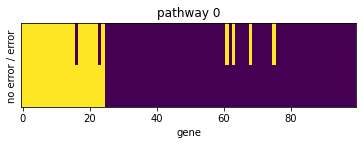

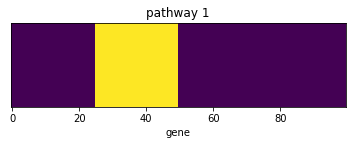

In [46]:
pathway_error_indicator = [True, False]

pathways = sampler.get_pathways(
  num_paths = 2,
  add_error = pathway_error_indicator,
  false_pos = 0.1,
  false_neg = 0.09,
  error_in_block = False
)

for pathway_index, error in enumerate(pathway_error_indicator):
  if not error:
    continue
  false_neg_num = 0
  false_pos_num = 0
  original_path = sampler.loadings_struct[:,pathway_index]
  sampled_path = pathways[pathway_index].boolean_genelist
  for original, sampled in zip(original_path, sampled_path):
    if original != sampled:
      if original:
        false_neg_num += 1
      else:
        false_pos_num += 1
  print(f"Error in pathway {pathway_index}")
  print(f"False negatives: {false_neg_num}")
  print(f"False positives: {false_pos_num}")

for i, path in enumerate(pathways):
  if pathway_error_indicator[i]:
    save_tensor(
      torch.cat(
        torch.atleast_2d(path.boolean_genelist, sampler.loadings_struct[:,i]), 
        dim = 0
      ),
      "gene", "no error / error ", dir + "/structure", 
      f"path_{i}", drop_y_ticks=True, title=f"pathway {i}"
    )
  else:
    save_tensor(
      path.boolean_genelist, "gene", "", dir + "/structure", 
      f"path_{i}", drop_y_ticks=True, title=f"pathway {i}"
    )

The following parameters must be tuned.

In [47]:
# MODEL PARAMETERS
extra_layer = False
# these give the number of elements in the various vectors 
dim_x = num_genes
unannotated_dim_z = num_facs - len(pathways)
dim_z = len(pathways) + unannotated_dim_z
in_W_dim = 3
out_W_dim = 3
# lambda sparsity parameters for in-pathway and out-pathway Ws respectively
dense_lam = 1e-2
sparse_lam = 2e1
prior_theta_scale = 1
# set this to None to use a Euclidean distance based reconstruction error
initial_logprob_sigma = None

In [48]:
# TRAINING PARAMETERS
num_train_samples = num_cells
num_epochs = 8000
mc_samples = 1
batch_size = 25

The following neural network will generate the latent variables that make up z.

In [49]:
# This value adjusts the impact of our learned variances in the sigma_net of
# `inference_net` below. Zero means that the model has no actual connection to
# the output and therefore the standard deviation defaults to the minimum. One
# means that we're learning the real model. This value is flipped to 1 after
# some number of iterations.
stddev_multiple = 0.1

if extra_layer:
  mu_net = torch.nn.Sequential(
    torch.nn.Linear(dim_x, dim_x//8),
    torch.nn.Sigmoid(),
    torch.nn.Linear(dim_x//8, dim_z)
  )
else:
  mu_net = torch.nn.Linear(dim_x, dim_z)

inference_net = NormalNet(

  mu_net=mu_net,

  # Learned standard deviation as a function of the input
  sigma_net=torch.nn.Sequential(
    # inference_net_base,
    torch.nn.Linear(dim_x, dim_z),
    Lambda(torch.exp),
    Lambda(lambda x: x * stddev_multiple + 1e-3)
  )
)

The following generates the annotated portion of the decoder, which takes each latent variable annotated with a pathway and reconstructs the gene expression associated with that pathway. Each latent variable is reconstructed through two generators, one for the genes in the pathway and one for the genes outside the pathway.

In [50]:
def make_in_pathway_gen(pathway):
  if extra_layer:
    return torch.nn.Sequential(
      torch.nn.Linear(in_W_dim, pathway.num_in//4),
      torch.nn.Sigmoid(),
      torch.nn.Linear(pathway.num_in//4, pathway.num_in)
    )
  else:
    return torch.nn.Linear(in_W_dim, pathway.num_in)

def make_out_pathway_gen(pathway):
  if extra_layer:
    return torch.nn.Sequential(
      torch.nn.Linear(out_W_dim, pathway.num_out//8, bias = False),
      torch.nn.SIgmo(),
      torch.nn.Linear(pathway.num_out//8, pathway.num_out, bias = False)
    )
  else:
    return torch.nn.Linear(out_W_dim, pathway.num_out)
    
annotated_generators = PalavaAnnotatedGenerator(
  pathways=pathways,
  in_path_generators=[make_in_pathway_gen(pathway) for pathway in pathways],
  out_path_generators=[make_out_pathway_gen(pathway) for pathway in pathways],
  in_W_dim=in_W_dim,
  out_W_dim=out_W_dim,
  output_dim=dim_x,
  sparse_lam=sparse_lam,
  dense_lam=dense_lam,
)

The following generates the unannotated portion of the reconstruction from the rest of the latent variables.

In [51]:
if extra_layer:
  unannotated_vae = torch.nn.Sequential(
    torch.nn.Linear(unannotated_dim_z, dim_x//4),
    torch.nn.Sigmoid(),
    torch.nn.Linear(dim_x//4, dim_x)
  )
else:
  unannotated_vae = torch.nn.Linear(unannotated_dim_z, dim_x)

Each of these components needs to be optimized, the learning rates may need tuning.

In [52]:
lr = 5e-3
optimizer_ann = torch.optim.Adam([
  {'params': inference_net.parameters(), 'lr': lr},
  {'params': annotated_generators.generators_parameters(), 'lr': lr},
])

Ws_lr = 1e-4
optimizer_Ws = torch.optim.SGD([
  {'params': [annotated_generators.in_Ws ], 'lr': Ws_lr, 'momentum': 0},
  {'params': [annotated_generators.out_Ws], 'lr': Ws_lr, 'momentum': 0}
])

unann_lr = 5e-3
optimizer_unann = torch.optim.SGD([
  {'params': unannotated_vae.parameters(), 'lr': unann_lr, 'momentum': 0}
])

Each component of the vae model is now ready, except for the prior used to calculate the KL divergence for the latent variables.

In [53]:
prior_z = Normal(
  Variable(torch.zeros(batch_size * mc_samples, dim_z)),
  Variable(torch.ones(batch_size * mc_samples, dim_z))
)

vae = PALAVA(
  pathways=pathways,
  inference_model=inference_net,
  annotated_generative_model=annotated_generators,
  unannotated_generative_model=unannotated_vae,
  prior_z=prior_z,
  prior_theta=NormalPriorTheta(prior_theta_scale),
  optimizers=[optimizer_unann, optimizer_ann, optimizer_Ws],
  initial_logprob_sigma=initial_logprob_sigma
)

We are now ready to train the model!

In [54]:
print_interval = max(num_epochs // 10, 1)
elbo_per_iter = []
for i in range(num_epochs):
  if i > num_epochs // 5:
    stddev_multiple = 1

  # [batch_size, dim_x]
  Xvar = Variable(X[torch.randperm(num_train_samples)[:batch_size]])

  info = vae.step(
    X=Xvar,
    Ws_lr=Ws_lr,
    mc_samples=mc_samples
  )

  elbo_per_iter.append(info['elbo'].data.item())

  if i % print_interval == 0 or i == num_epochs - 1:
    print()
    print('iter', i)
    print('  ELBO:', info['elbo'].data.item())
    print('    -KL(q(z) || p(z))', -info['z_kl'].data.item())
    print('    loglik term      ', info['loglik_term'].item())
    print('    log p(theta)     ', info['logprob_theta'].data.item())
    print('    log p(W)         ', info['logprob_W'].data.item())
    print(
      '    avg W-in  signal  ', 
      float(torch.mean(torch.abs(vae.annotated_generative_model.in_Ws)))
    )
    print(
      '    avg W-out signal  ', 
      float(torch.mean(torch.abs(vae.annotated_generative_model.out_Ws)))
    )



iter 0
  ELBO: -1862.3951416015625
    -KL(q(z) || p(z)) -9.237571716308594
    loglik term       -989.3460083007812
    log p(theta)      -779.6898193359375
    log p(W)          -84.12165832519531
    avg W-in  signal   1.1216181516647339
    avg W-out signal   1.0107715129852295

iter 800
  ELBO: -814.775390625
    -KL(q(z) || p(z)) -18.772321701049805
    loglik term       -23.14800262451172
    log p(theta)      -738.38232421875
    log p(W)          -34.472713470458984
    avg W-in  signal   1.1102416515350342
    avg W-out signal   0.42013785243034363

iter 1600
  ELBO: -803.4675903320312
    -KL(q(z) || p(z)) -22.77456283569336
    loglik term       -32.57352828979492
    log p(theta)      -737.93359375
    log p(W)          -10.185942649841309
    avg W-in  signal   1.1088107824325562
    avg W-out signal   0.13537101447582245

iter 2400
  ELBO: -789.217529296875
    -KL(q(z) || p(z)) -20.215351104736328
    loglik term       -28.816150665283203
    log p(theta)      -737.606

Now that the model has been trained, we want to visualise the various things that it has learned.

In [55]:
# View the W matrices in and out of each pathway 
# All 0s in pathway i for W out means zi doesn't affect genes outside pathway i
print("W in:")
print(annotated_generators.in_Ws.data.squeeze())
print("W out:")
print(annotated_generators.out_Ws.data.squeeze())


W in:
tensor([[-1.0874, -1.1740, -0.6480],
        [-0.9669, -1.7344,  1.2565]])
W out:
tensor([[ 0.0461,  0.0331, -0.0559],
        [ 0.0000,  0.0000,  0.0000]])


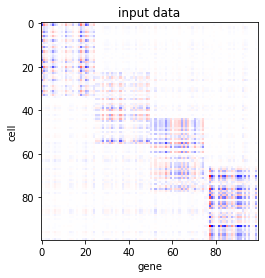

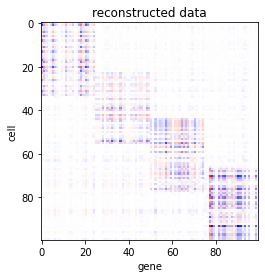

In [56]:
# Visualise the reconstructions to check they match the data

# the latent representation of each cell
activations = inference_net(Variable(X)).mu
# the model's reconstruction of each cell
reconstructions = vae.decode(activations).detach()

data_norm = get_combined_norm(X, reconstructions)

save_tensor(
  X, "gene", "cell", dir + "/structure", "input_data",
  scale_norm=data_norm, title="input data", cmap="bwr"
)
save_tensor(
  reconstructions, 
  "gene", "cell", dir + "/structure", "reconstructed_all_data",
  scale_norm=data_norm, title="reconstructed data", cmap="bwr"
)

We can also break down the reconstruction by annotated/unnanotated sections to
see which latent variables contribute to which entries. In the case that
genes have been added to a pathway, we can also break down that pathway
into 'previously-considered in' and 'previously-considered out'

We will also sum all components in the 'sum' tensor to check the components sum 
to the original.

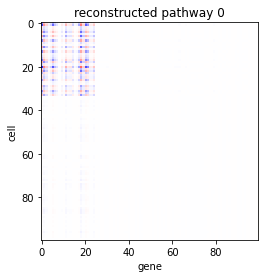

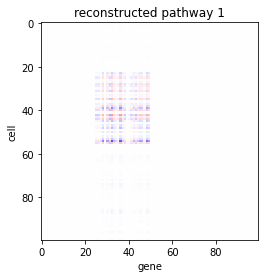

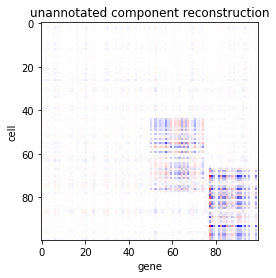

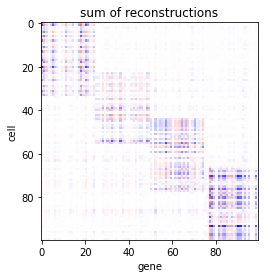

In [57]:
num_paths = len(pathways)

sum = torch.zeros_like(X) 
unannotated_component = (
  vae.unannotated_generative_model(activations[:,num_paths:]).detach()
)
sum = sum.add(unannotated_component)

for pathway_index in range(num_paths):
  pathway_contribution = vae.annotated_generative_model.pathway_expression(
    activations[:,:num_paths],
    pathway_index
  ).detach()
  
  save_tensor(
    pathway_contribution, 
    "gene", "cell", dir + "/structure", 
    f"pathway {pathway_index} reconstruction", scale_norm=data_norm,
    title=f"reconstructed pathway {pathway_index}", cmap="bwr"
  )
  sum = sum.add(pathway_contribution)

save_tensor(
  unannotated_component,
  "gene", "cell", dir + "/structure", 
  "reconstructed_unannotated_compnt", scale_norm=data_norm,
  title="unannotated component reconstruction", cmap="bwr"
)
save_tensor(
  sum.detach(), 
  "gene", "cell", dir + "/structure", 
  "reconstructed_components_summed", scale_norm=data_norm, 
  title="sum of reconstructions", cmap="bwr"
)

The model appears to have reconstructed the data from the expected latent variables. We can now inspect whether the error in pathway 0 was corrected - Wout0 was non-zero which is promising, and we can break down the reconstruction to visualise:

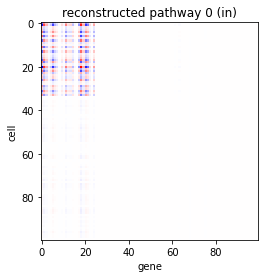

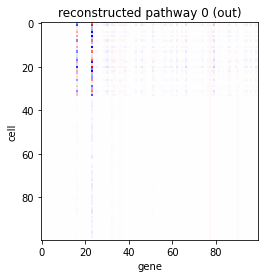

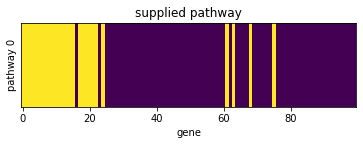

In [58]:
for pathway_index in range(num_paths):
  if torch.sum(torch.abs(annotated_generators.out_Ws[pathway_index])) > 0:
    in_path_cmpnt = vae.annotated_generative_model.pathway_expression(
        activations[:,:num_paths],
        pathway_index,
        in_path_only=True
    ).detach()

    out_of_path_cmpnt = vae.annotated_generative_model.pathway_expression(
        activations[:,:num_paths],
        pathway_index,
        out_of_path_only=True
    ).detach()
    
    path_norm = get_combined_norm(in_path_cmpnt, out_of_path_cmpnt)

    save_tensor(
      in_path_cmpnt, 
      "gene", "cell", dir + "/structure", 
      f"pathway {pathway_index} reconstruction (in)", ind_norm=True,
      title=f"reconstructed pathway {pathway_index} (in)",
      cmap="bwr", scale_norm = path_norm
    )
    save_tensor(
      out_of_path_cmpnt, 
      "gene", "cell", dir + "/structure", 
      f"pathway {pathway_index} reconstruction (out)",
      title=f"reconstructed pathway {pathway_index} (out)", ind_norm=True,
      cmap="bwr", scale_norm = path_norm
    )
    save_tensor(
      pathways[pathway_index].boolean_genelist.t(),
      "gene", f"pathway {pathway_index}", dir + "/structure",
      f"path_{pathway_index}", title="supplied pathway", drop_y_ticks=True
    )

It can be seen that model has corrected the incorrect pathway 0. The two genes that were incorrectly removed when supplying the model with the pathway have been added back by the model, as shown by the two vertical bands in the 'reconstructed pathway 0 (out)' plot, while the incorrectly added genes have been ignored as seen in the 'reconstructed pathway 0 (in)'. The model therefore appears to have inferred the correct pathway, at least at a glance.

This is just from a rough overview however, we might need a better way to assess which genes have been included or not in a pathway. To do this we will plot histograms of genes in the pathway and not in the pathway to determine the distribution of the gene expression in and out of the pathway:

[12, 63, 13, 1, 8]
[92, 89, 78, 62, 88]
in: gene 12 ; 0.035010870546102524


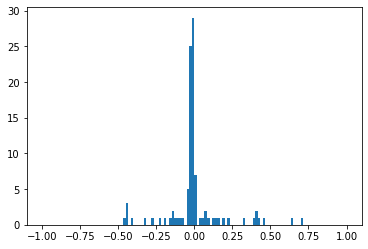

in: gene 63 ; 0.00033072999212890863


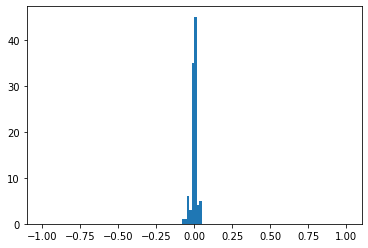

in: gene 13 ; 0.04865936189889908


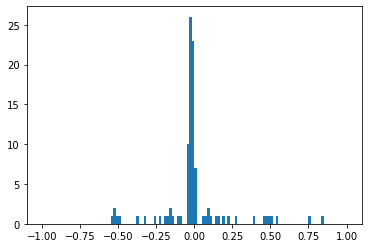

in: gene 1 ; 0.832960307598114


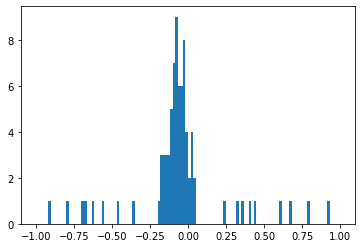

in: gene 8 ; 0.000600974599365145


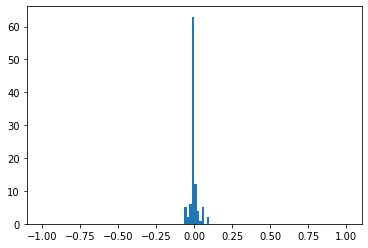

out: gene 92 ; 2.5530896436976036e-06


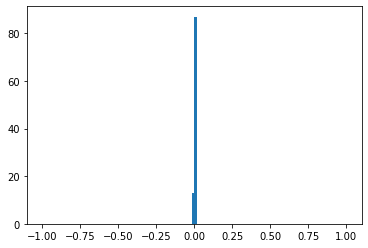

out: gene 89 ; 2.515346022846643e-05


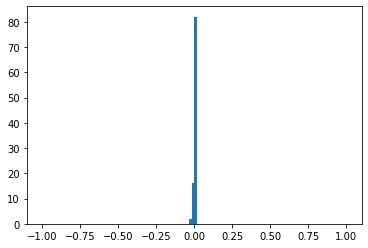

out: gene 78 ; 4.9392889195587486e-05


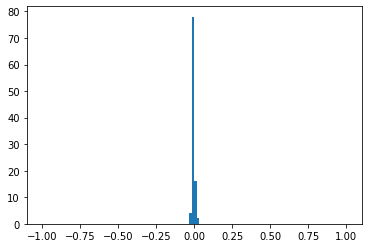

out: gene 62 ; 0.00010069172276416793


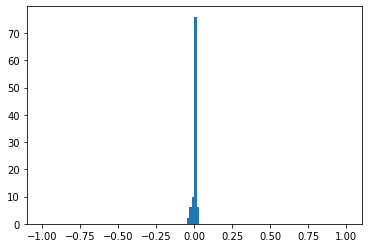

out: gene 88 ; 2.4979161139526695e-07


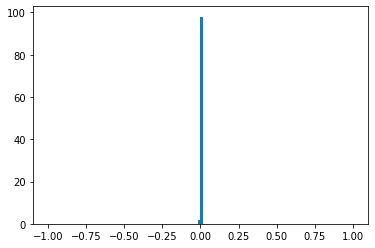

In [59]:
num_examples = 5

pathway_0_contribution = vae.annotated_generative_model.pathway_expression(
  activations[:,:num_paths],
  0
).detach()

sample_genes_in = random.sample(pathways[0].indexes_in, num_examples)
sample_genes_out = random.sample(pathways[0].indexes_out, num_examples)

print(sample_genes_in)
print(sample_genes_out)

granularity = 60
for i in range(5):
  print(f"in: gene {sample_genes_in[i]}", end="")
  sample_expression_in = pathway_0_contribution[:,sample_genes_in[i]]
  print(f" ; {torch.var(sample_expression_in)}")
  sample_expression_in = [float(i) for i in sample_expression_in]
  plt.hist(
    sample_expression_in, 
    bins = [i/granularity for i in range(-granularity, granularity + 1)]
  )
  plt.show()

for i in range(5):
  print(f"out: gene {sample_genes_out[i]}", end="")
  sample_expression_out = pathway_0_contribution[:,sample_genes_out[i]]
  print(f" ; {torch.var(sample_expression_out)}")
  sample_expression_out = [float(i) for i in sample_expression_out]
  plt.hist(
    sample_expression_out, 
    bins = [i/granularity for i in range(-granularity, granularity + 1)]
  )
  plt.show()


It appears that genes not in the pathway have a sharp peak at 0, with values in only a few bins. Whereas the values in the pathway have a more spread out distribution, with the exception of gene 63 - this is an impostor and in fact it does not belong in the pathway as it is one of the genes included as error. This suggests that the variance of each gene's expression in pathway 0 might help indicate whether it belongs to the pathway. We visualise their logarithm to see if any clusters emerge:

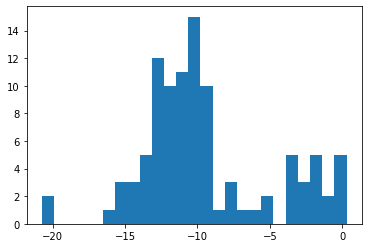

25
0.000600974599365145


In [66]:
gene_variances = torch.zeros(num_genes)
for i in range(num_genes):
  gene_variances[i] = torch.var(pathway_0_contribution[:,i])

gene_hist = [float(i) for i in torch.log(gene_variances)]
plt.hist(gene_hist, bins = 25)
plt.show()

top = [float(var) for var in gene_variances if var > 5e-4]
print(len(top))
print(min(top))

We can see that there is a cluster of genes at the top end, above about 5e-4 or 0.0005. Using this as a decision tool, we can now assess whether the model has actually learned the true pathway 0:

Error in learned pathway 0:
False negatives: 0
False positives: 0


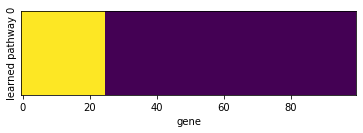

In [61]:
threshold = 0.0005
learned_pathway = torch.zeros(num_genes)
for i in range(num_genes):
  learned_pathway[i] = torch.var(pathway_0_contribution[:,i]) > threshold
save_tensor(
  learned_pathway, "gene", "learned pathway 0",  dir + "/structure", 
  "learned_pathway_0", drop_y_ticks=True
)

false_neg_num = 0
false_pos_num = 0
for original, sampled in zip(original_path, learned_pathway):
  if original != sampled:
    if original:
      false_neg_num += 1
    else:
      false_pos_num += 1
print(f"Error in learned pathway 0:")
print(f"False negatives: {false_neg_num}")
print(f"False positives: {false_pos_num}")

Success! We can now visually see that the model has assigned the genes their true classifications, rather than the incorrect ones we supplied the model with.

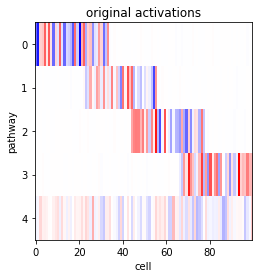

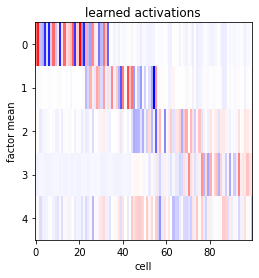

In [62]:
# Visualise the activations we specified alongside the learned activations, 
# on the same scale. This indicates how well the model has learned the
# underlying representation

learned_activations = activations.data.t()

# overwrite earlier sampler.activations file with new scale
save_tensor(
  sampler.activations, "cell", "pathway", dir + "/structure", 
  "activations", title="original activations", cmap="bwr", ind_norm=True
)
save_tensor(
  learned_activations, "cell", "factor mean", dir + "/structure", 
  "activations_learned", title="learned activations", cmap="bwr", ind_norm=True
)

Note that the order of the unannotated variables isn't consistent, as the model may discover them in any order. Additionally, the sign of the rows in the learned activations matrix will not necessarily match the original specifed activations, since the sign can easily be flipped during multiplication with W or the weights in the generators. Purely to visualise the above factors with the correct sign and order, we permute the possible orderings of unannotated factors and the sign of all factors and iterate through to find the closest match to the true pathways specified.

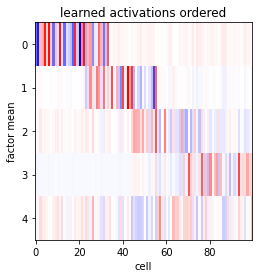

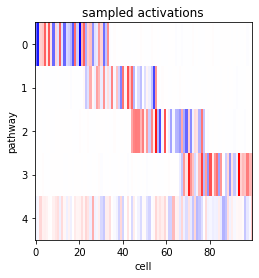

In [63]:
def alternative_sign_and_order(sign_string, order_tuple):
  matrix = learned_activations.clone()
  for row, sign_indicator in enumerate(sign_string):
    if (sign_indicator == "0"):
      matrix[row] *= -1
  matrix[num_paths:] = torch.index_select(
      matrix[num_paths:],
      dim = 0, 
      index = Variable(torch.LongTensor(order_tuple))
    )
  return matrix

min_distance = None
for order_tuple in permutations(range(unannotated_dim_z)):
  for binary_number in range(2**num_facs):
    binary_number_string = format(binary_number, '0' + str(num_facs) + 'b')
    alternative = alternative_sign_and_order(binary_number_string, order_tuple)
    distance = torch.mean(
      LA.vector_norm(alternative - sampler.activations, dim = 1)
    )
    if min_distance is None or distance < min_distance:
      nearest_alternative = alternative
      min_distance = distance

save_tensor(
  nearest_alternative, "cell", "factor mean", dir + "/structure", 
  "activations_learned_ordered",
  title="learned activations ordered", cmap="bwr", ind_norm=True
)
save_tensor(
  sampler.activations, "cell", "pathway", dir + "/structure", 
  "activations", title="sampled activations", cmap="bwr", ind_norm=True
)

Finally, we are able to see that the model has indeed learned all the factors correctly, as each row in the above 2 matrices matches up closely. It can also be seen that the annotated learned factors are more defined than the non-annotated ones, showing the value of the prior pathway information.

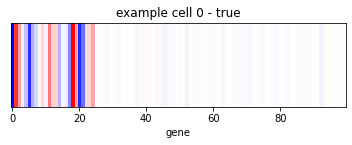

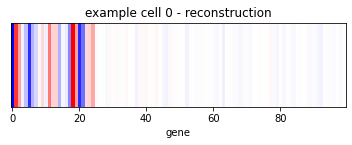

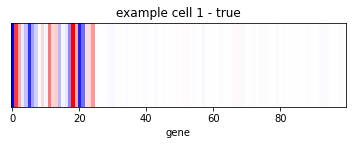

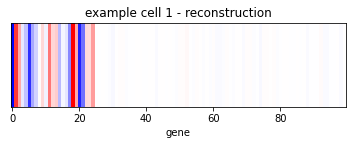

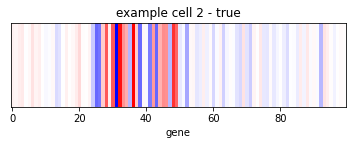

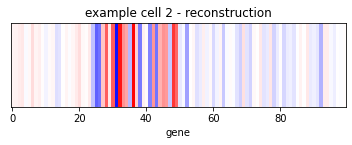

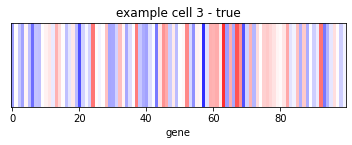

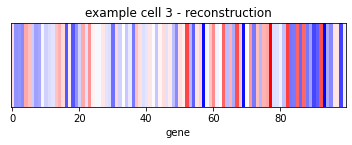

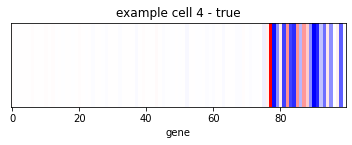

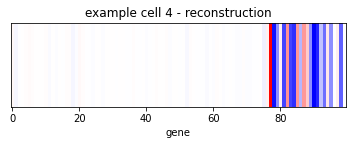

In [64]:
# Finally, visualise a few samples to see howz they were reconstructed
def save_img_and_reconstruction(image_index, sample):
  Xvar = Variable(X[[sample]])
  z = inference_net(Xvar).sample()
  Xdash = vae.decode(z).view(dim_x, 1)
  sample_norm = get_combined_norm(Xvar, Xdash)
  save_tensor(
    Xvar.data.contiguous().view(1, dim_x), 
    "gene", 
    "", 
    dir + "/reconstructions",
    'example_{}_true'.format(image_index), 
    scale_norm=sample_norm,
    title='example cell {} - true'.format(image_index),
    drop_y_ticks=True,
    cmap="bwr"
  )
  save_tensor(
    Xdash.data.t(), 
    "gene", 
    "", 
    dir + "/reconstructions", 
    'example_{}_reconstruction'.format(image_index),
    scale_norm=sample_norm,
    title='example cell {} - reconstruction'.format(image_index),
    drop_y_ticks=True,
    cmap="bwr"
  )

num_examples = 5
for image_index, sample in enumerate(range(0, num_cells, num_cells//num_examples)):
  save_img_and_reconstruction(image_index, sample)